### Validation of the trianed models

In [47]:
# Packages
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.models import Prophet, TFTModel
from darts import TimeSeries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

In [3]:
# ====================================== Plot features ========================================== #
# Properties to decorate the plots.
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'   
plt.rcParams['font.sans-serif'] = 'New Century Schoolbook' # 'Times', 'Liberation Serif', 'Times New Roman'
#plt.rcParams['font.serif'] = ['Helvetica']
plt.rcParams['font.size'] = 10   # Antes era 15
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['legend.markerscale'] = 1
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width']= 0.5
plt.rcParams['xtick.major.size']= 5.0
plt.rcParams['xtick.minor.width']= 0.5
plt.rcParams['xtick.minor.size']= 3.0
plt.rcParams['ytick.major.width']= 0.5
plt.rcParams['ytick.major.size']= 5.0
plt.rcParams['ytick.minor.width']= 0.5
plt.rcParams['ytick.minor.size']= 3.0
# =============================================================================================== #

In [236]:
# Load the dataset
#df = pd.read_csv('../../data/final_datasets/time_series/transformed_time_series/transformed_time_series_by_store/chips/chips_S00139_time_series.csv', index_col = 'DATE', parse_dates = True)
df = pd.read_csv('../../../../../../Programacion/Data Science Competitions/asterion-demand-forecasting/data/final_datasets/time_series/transformed_time_series/transformed_time_series_by_store/pants/pants_S00101_time_series.csv', index_col = 'DATE', parse_dates = True)

<Axes: xlabel='DATE'>

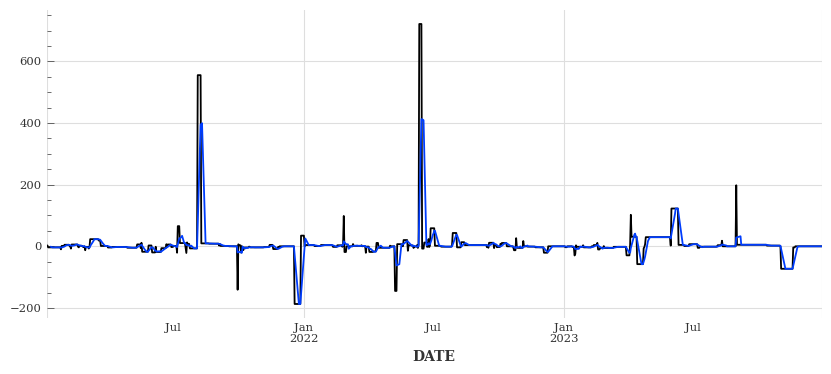

In [237]:
df.loc[:, 'elasticity'].plot(figsize=(10,4))
df.loc[:, 'elasticity'].rolling(window = 7, min_periods = 7).mean().plot(figsize=(10,4))

In [238]:
# Load the trained model
#with open('trained_models/chips/chips_S00139_TFT.pkl', 'rb') as file:
#    trained_model = pickle.load(file)
    
trained_model = TFTModel.load('../../../../../../Programacion/Data Science Competitions/asterion-demand-forecasting/src/data_mining/trained_models/pants/pants_S00139_TFT.pkl')

In [239]:
target = ['daily_total_sales']
past_covariates = ["daily_average_quantity",
                   "daily_total_quantity",
                   "daily_dispersion_quantity", 
                   "daily_average_price", 
                   "daily_dispersion_price", 
                   "daily_dispersion_total_sales",
                   "daily_percentage_change_total_sales",
                   "daily_percentage_change_total_quantity",
                   "daily_percentage_change_average_price"]
future_covariates = ["elasticity"]

days_to_predict = 7

# Shift the covariates
#df_tmp = df.shift(7, freq = 'D')
                
# Drop the NaN values generated by the shift
#df_tmp.dropna(inplace = True)

y = TimeSeries.from_dataframe(df[:-days_to_predict], value_cols = target)
past_cov = TimeSeries.from_dataframe(df[:-days_to_predict], value_cols = past_covariates)
future_cov = TimeSeries.from_dataframe(df, value_cols = future_covariates)

predictions = trained_model.predict(n = days_to_predict, num_samples = 100, series = y, past_covariates = past_cov, future_covariates = future_cov)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/scollazo/anaconda3/envs/env-asterion25/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/scollazo/anaconda3/envs/env-asterion25/lib/python3.13/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  0.32it/s]


In [240]:
r2_score(y_pred = predictions.all_values().mean(axis = 2), y_true = df['daily_total_sales'].iloc[-days_to_predict:])

-0.0018191654491315212

In [241]:
predictions.all_values().mean(axis = 2)

array([[43.94625071],
       [41.0445716 ],
       [-0.69429639],
       [-0.72260714],
       [-0.81260589],
       [42.48924163],
       [44.19211435]])

/tmp/ipykernel_1529/1078896770.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


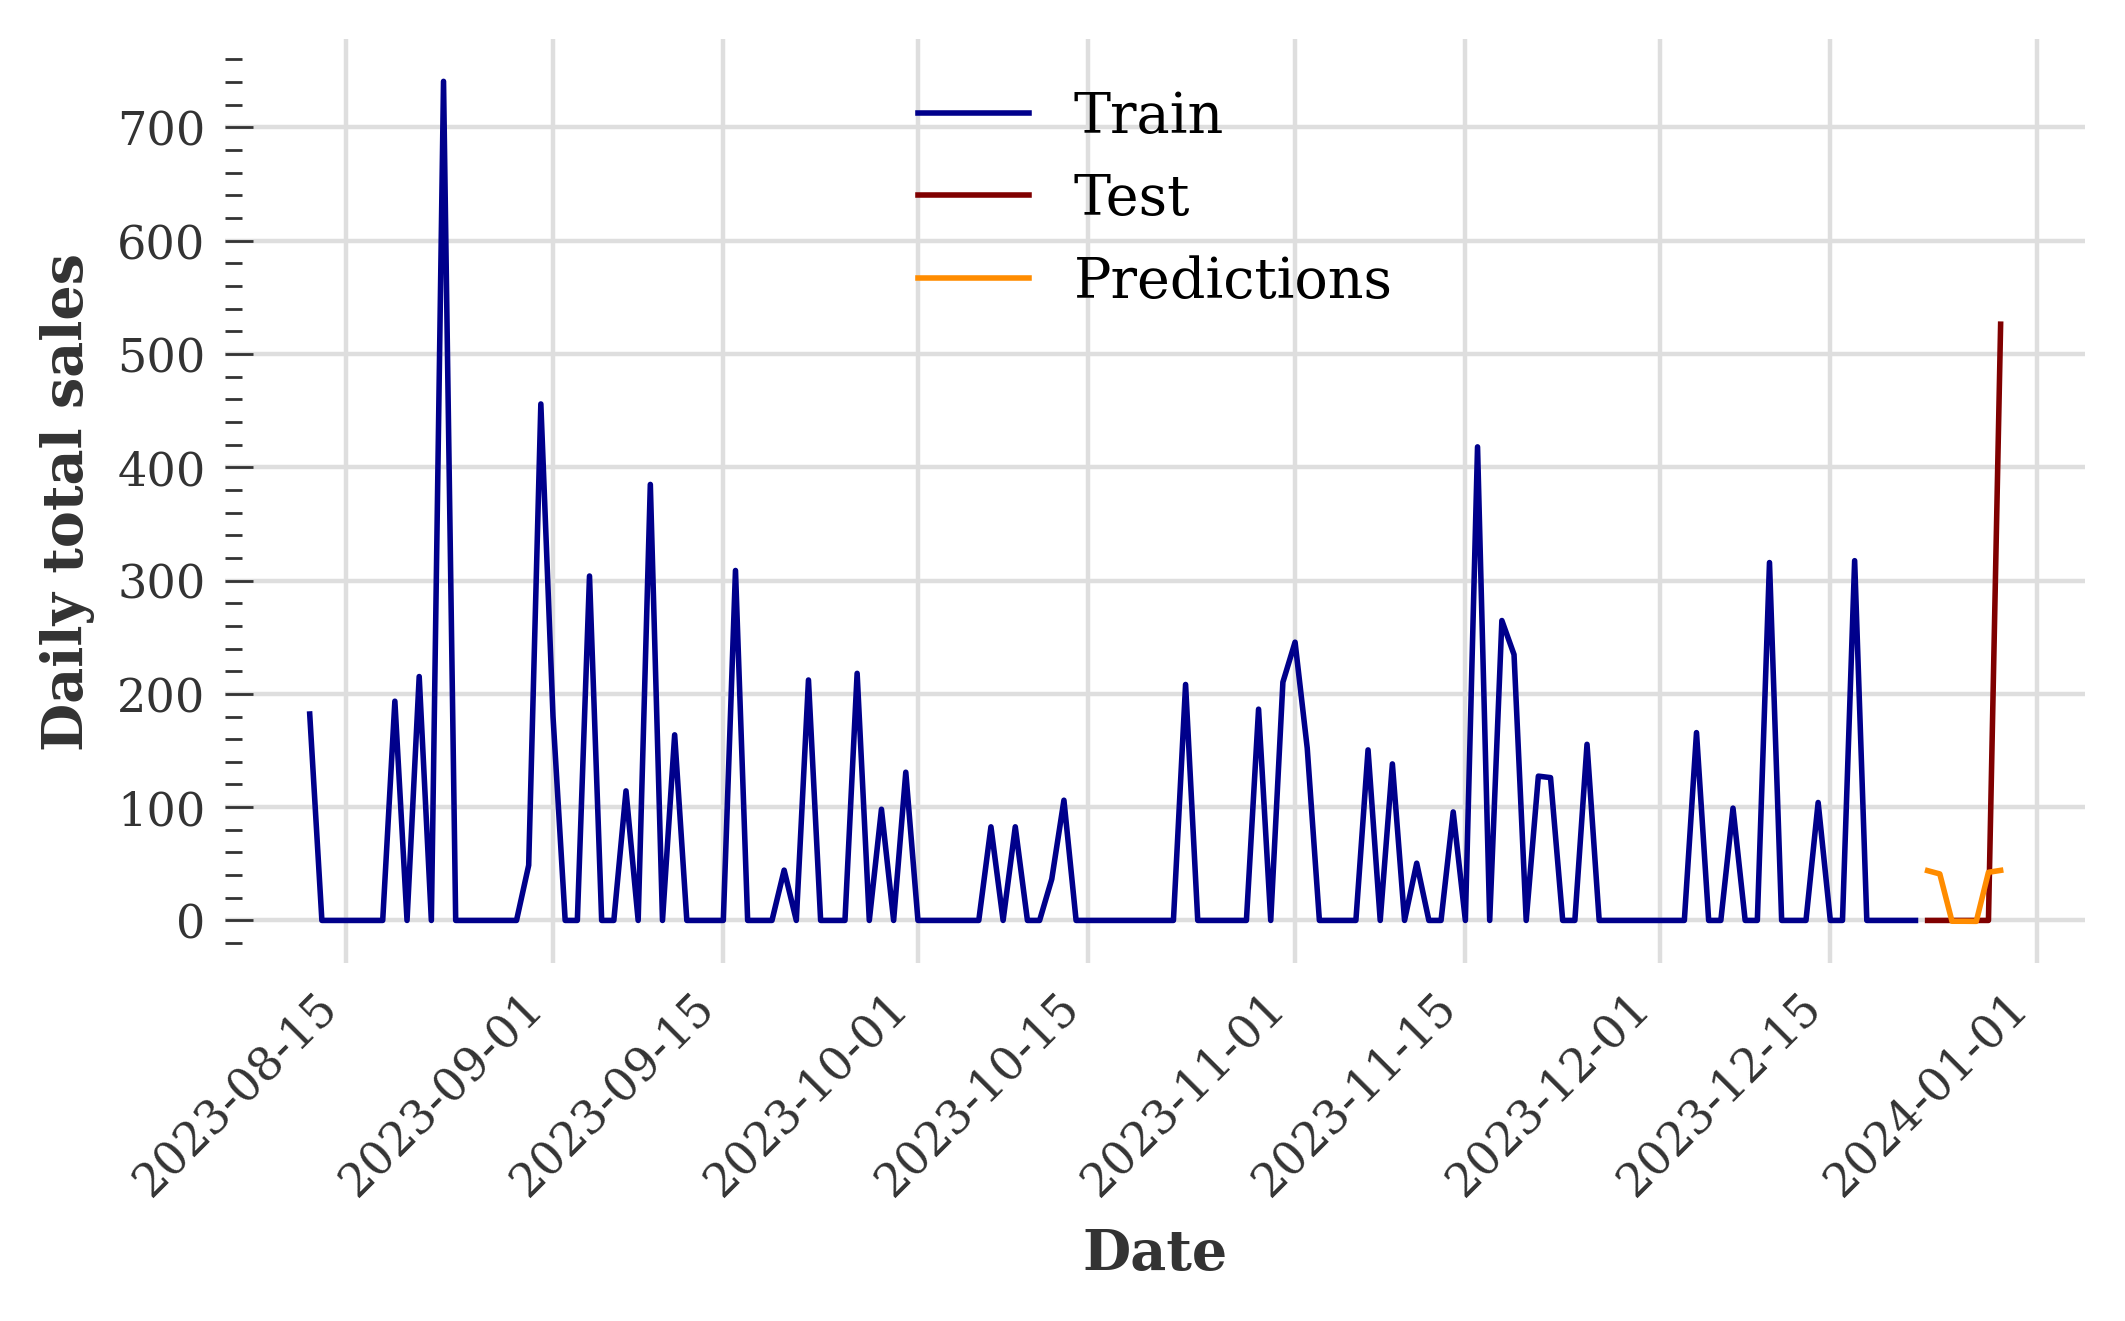

In [242]:
# Initial date
initial_date = '2023-05-01'
split_date = '2023-10-31'
line_width = 1.0

# Plot
fig, ax = plt.subplots(1, 1, figsize = (6, 3), dpi = 400)
ax.plot(df['daily_total_sales'].iloc[-days_to_predict*20:-days_to_predict], lw = line_width, color = 'darkblue', label = 'Train')
ax.plot(df['daily_total_sales'].iloc[-days_to_predict:], lw = line_width, color = 'maroon', label = 'Test')
ax.plot(df['daily_total_sales'].iloc[-days_to_predict:].index, predictions.all_values().mean(axis = 2), lw = line_width, color = 'darkorange', label = 'Predictions')
ax.set_xlabel('Date')
ax.set_ylabel('Daily total sales')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend()
plt.show()